In [1]:
# Run the imports we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
mnist = np.genfromtxt('MNIST_Shortened.csv', delimiter=',', skip_header=1)
# Define X and y

X = mnist[:,0:784]
y = mnist[:,-1]

# Check dimensions of X
X.shape

(6000, 784)

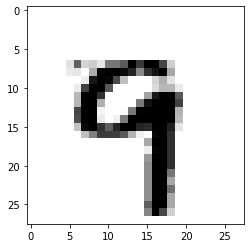

In [7]:
# we can use the Numpy reshape function along with the matplotlib imshow function to visualise

plt.imshow(X[0].reshape(28,28),cmap='gray_r')

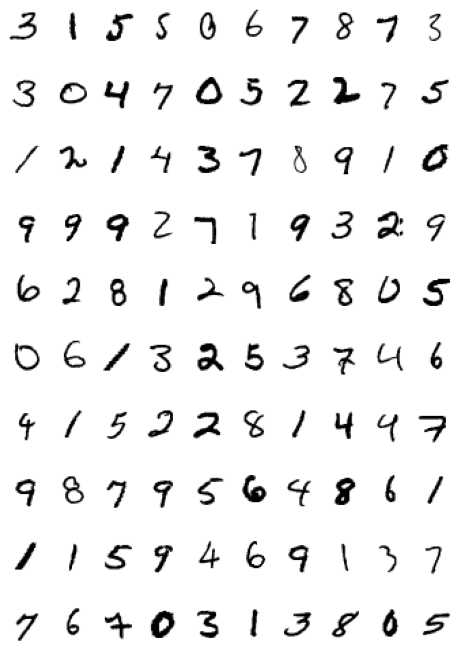

In [8]:
plt.figure(figsize=(8, 12))

for i in range(100):
 plt.subplot(10,10,i+1)
 plt.imshow(X[np.random.randint(0,6000)].reshape(28,28),cmap='gray_r')
 plt.axis('off')

plt.show()

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3, random_state=0, stratify=y)


In [11]:
from sklearn.feature_selection import VarianceThreshold

variance_selector = VarianceThreshold(threshold=0)

X_train_fs = variance_selector.fit_transform(X_train)
X_test_fs = variance_selector.transform(X_test)

print(f"{X_train.shape[1]-X_train_fs.shape[1]} features have been removed, {X_train_fs.shape[1]} features remain")


118 features have been removed, 666 features remain


<AxesSubplot:>

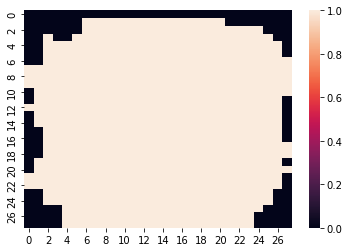

In [12]:
# We can use the get_support function to see which features have been dropped

selected_features = variance_selector.get_support()
selected_features = selected_features.reshape(28,28)

# Visualise which pixels have been dropped
sns.heatmap(selected_features,cmap='rocket')

In [13]:
# Use the SelectKBest selector from sklearn to select the k features with the best scores on a selected test statistic

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=200)

X_train_fs = selector.fit_transform(X_train_fs, y_train)
X_test_fs = selector.transform(X_test_fs)

In [14]:
# Create boolean array for all features
new_features_indices = \
variance_selector.get_support(indices=True)[selector.get_support()]
new_features_boolean = np.isin(np.arange(784), new_features_indices)

<AxesSubplot:>

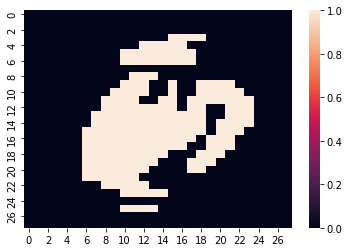

In [15]:
# Reshape and plot as a heatmap
sns.heatmap(new_features_boolean.reshape(28,28),cmap='rocket')

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV

In [17]:
# Standardise data before passing to model
scaler = StandardScaler()
X_train_fs = scaler.fit_transform(X_train_fs)
X_test_fs = scaler.transform(X_test_fs)

In [18]:
rf = RandomForestClassifier(random_state=0) 
# Use RandomForestClassifier as the base model
rfecv = RFECV(rf, cv=3, step=5)
X_train_fs = rfecv.fit_transform(X_train_fs, y_train)
X_test_fs = rfecv.transform(X_test_fs)
print(f"Number of remaining features: {X_train_fs.shape[1]}")

Number of remaining features: 195


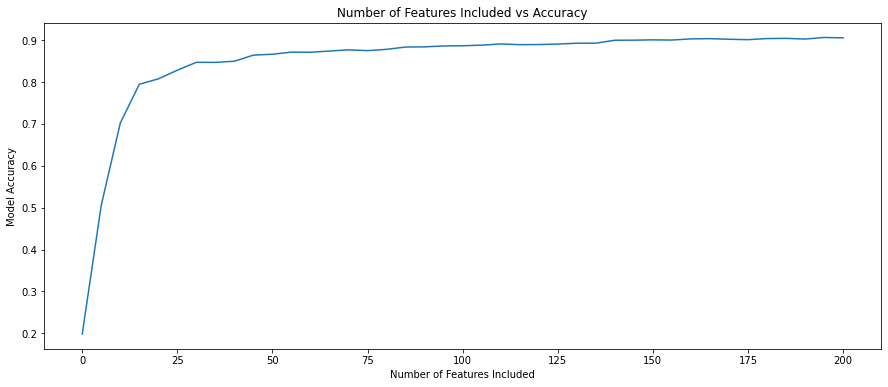

In [20]:
plt.figure( figsize=(15, 6))
plt.title('Number of Features Included vs Accuracy')
plt.xlabel('Number of Features Included')
plt.ylabel('Model Accuracy')
plt.plot(np.linspace(0,200,41), rfecv.cv_results_['mean_test_score'])
plt.show()

In [21]:
rf_selectedfeatures = RandomForestClassifier()
rf_selectedfeatures.fit(X_train_fs, y_train)

RandomForestClassifier()

Accuracy Score: 90.67%


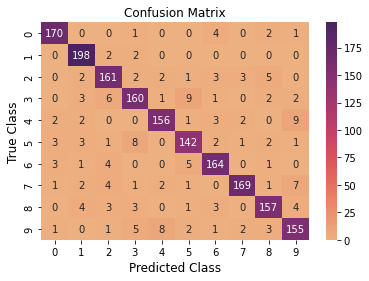

In [22]:
# Make predictions on the test data
y_pred = rf_selectedfeatures.predict(X_test_fs)

print(f"Accuracy Score: {accuracy_score(y_test,y_pred)*100:.2f}%")

cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm, cmap='flare',annot=True, fmt='d')
plt.xlabel("Predicted Class",fontsize=12)
plt.ylabel("True Class",fontsize=12)
plt.title("Confusion Matrix",fontsize=12)
plt.show()
